# Step 1: Problem Definition and Requirements

**Objective:**  
Predict travel time (duration in seconds) for ride trips given start and end locations (specified in WGS84 coordinates) and a departure datetime.

**Datasets:**  
- **train.csv:** Contains columns:
  - `row_id`, `start_lng`, `start_lat`, `end_lng`, `end_lat`, `datetime`, `duration`
- **test.csv:** Contains columns:
  - `row_id`, `start_lng`, `start_lat`, `end_lng`, `end_lat`, `datetime`

**Evaluation Metric:**  
Root Mean Squared Error (RMSE) computed as:  
```python
RMSE = sqrt(mean_squared_error(prediction, ground_truth))

# 2. Data Ingestion and Exploration

In this step, we load the training and test datasets, inspect their structure, and conduct initial exploratory analysis to understand the underlying data characteristics. This exploration helps identify potential issues (such as missing values and outliers) and informs subsequent feature engineering and modeling steps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

- Read the `train.csv` and `test.csv` files using pandas.
- Parse the `datetime` column into datetime objects for easier temporal manipulation later.

In [ ]:
train = pd.read_csv('train.csv', parse_dates=['datetime'])
test = pd.read_csv('test.csv', parse_dates=['datetime'])

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0
2,2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0
4,4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0


## Initial Inspection

- Display the first few rows of each dataset with `.head()` to get an overview.
- Use `.info()` to review data types and non-null counts, which aids in detecting missing or inconsistent data.
- Generate summary statistics with `.describe()` to understand the distribution, central tendency, and spread of numerical features.

In [17]:
train.head()

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0
2,2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0
4,4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0


In [16]:
test.head()

,row_id,start_lng,start_lat,end_lng,end_lat,datetime
0,0,-74.001488,40.726170,-73.962097,40.764500,2015-06-27 23:58:40
1,1,-122.454077,37.774170,-122.428070,37.777023,2012-09-10 01:32:00
2,2,-73.976753,40.751575,-73.789917,40.646965,2015-09-26 11:24:54
3,3,-122.405967,37.778165,-122.430198,37.759545,2012-09-03 05:21:00
4,4,-73.988197,40.750187,-73.872711,40.774292,2015-02-12 09:48:39


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146001 entries, 0 to 146000
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   row_id     146001 non-null  int64         
 1   start_lng  145601 non-null  float64       
 2   start_lat  146001 non-null  float64       
 3   end_lng    146001 non-null  float64       
 4   end_lat    145401 non-null  float64       
 5   datetime   146001 non-null  datetime64[ns]
 6   duration   146001 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 7.8 MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   row_id     30000 non-null  int64         
 1   start_lng  30000 non-null  float64       
 2   start_lat  30000 non-null  float64       
 3   end_lng    30000 non-null  float64       
 4   end_lat    30000 non-null  float64       
 5   datetime   30000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.4 MB


In [13]:
train.describe()

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
count,146001.000000,145601.000000,146001.000000,146001.000000,145401.000000,146001,146001.000000
mean,73000.000000,-86.465695,39.913703,-87.177163,39.922772,2014-09-12 22:40:34.780385280,1063.222314
min,0.000000,-122.515832,37.459648,-122.634420,37.225640,2012-09-01 00:00:00,0.000000
25%,36500.000000,-122.393532,37.798430,-122.392458,37.800318,2012-09-13 21:16:00,382.000000
50%,73000.000000,-73.989830,40.741089,-73.988754,40.740990,2015-04-16 03:37:24,631.000000
75%,109500.000000,-73.974190,40.762104,-73.971245,40.762669,2015-08-19 00:46:17,1020.000000
max,146000.000000,74.100212,40.994354,-50.336068,41.005390,2016-01-01 03:49:39,42168.000000
std,42147.002663,25.468467,1.339508,22.225753,1.336437,NaN,3305.905829


## Missing Values Analysis

- Identify missing data with `.isnull().sum()`, ensuring data integrity and determining if imputation or cleaning is required.

In [14]:
train.isnull().sum()

row_id         0
start_lng    400
start_lat      0
end_lng        0
end_lat      600
datetime       0
duration       0
dtype: int64

In [15]:
test.isnull().sum()

row_id       0
start_lng    0
start_lat    0
end_lng      0
end_lat      0
datetime     0
dtype: int64

In [83]:
train['missing_coords'] = train[['start_lng', 'end_lat']].isnull().any(axis=1)
missing_count = train['missing_coords'].sum()
total_rows = train.shape[0]
print(f"Missing coordinate rows: {missing_count} out of {total_rows}")
print("\nSummary statistics for 'duration' by missing indicator:")
print(train.groupby('missing_coords')['duration'].describe())

Missing coordinate rows: 1000 out of 146001


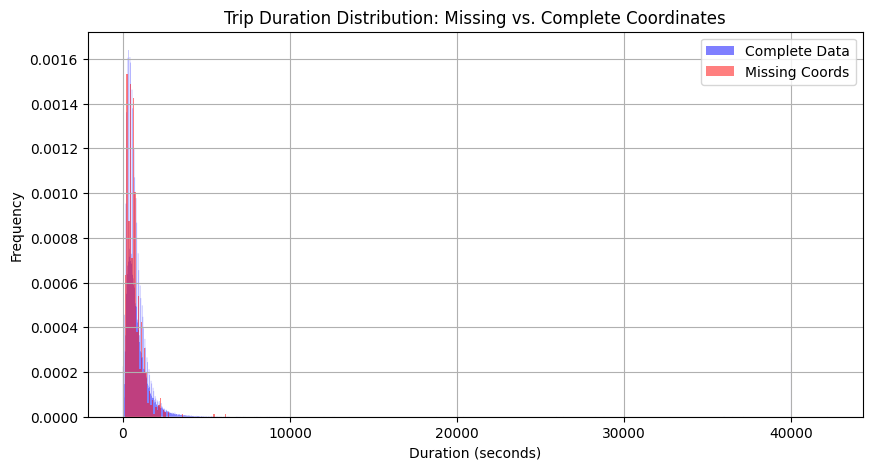

In [106]:
plt.figure(figsize=(10, 5))
plt.hist(train.loc[~train['missing_coords'], 'duration'], bins='auto', alpha=0.5, label='Complete Data', color='blue', histtype='stepfilled', density=True)
plt.hist(train.loc[train['missing_coords'], 'duration'], bins='auto', alpha=0.5, label='Missing Coords', color='red', histtype='stepfilled', density=True)
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Trip Duration Distribution: Missing vs. Complete Coordinates")
plt.legend()
plt.grid()
plt.show()

## Exploratory Visualizations

- Trip Duration Distribution: A histogram (with kernel density estimation) is plotted to understand the distribution of trip durations, highlighting skewness or outliers.
- Geospatial Distribution: Scatter plots of the start and end locations reveal spatial patterns or clustering, which might indicate regional trends or anomalies.
- Temporal Patterns: Extracting the hour from the `datetime` field and plotting trip counts by hour provides insight into peak travel times and daily usage patterns.


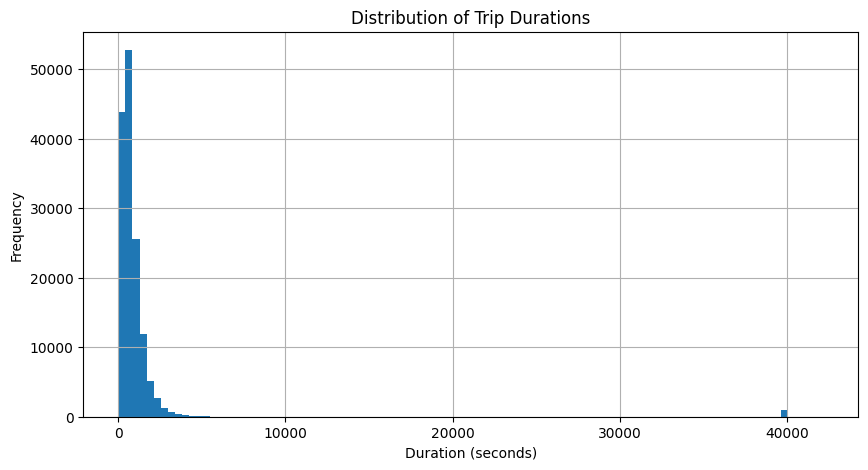

In [75]:
plt.figure(figsize=(10, 5))
plt.hist(train['duration'], bins=100)
plt.title("Distribution of Trip Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [113]:
q1 = train['duration'].quantile(0.25)
q3 = train['duration'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

Lower bound: -572.5
Upper bound: 1975.5


In [115]:
# calculate the share of trips with duration outliers
outliers = train[(train['duration'] < lower_bound) | (train['duration'] > upper_bound)]
outlier_share = outliers.shape[0] / train.shape[0]
print(f"Share of trips with duration outliers: {outlier_share:.2f}")

Share of trips with duration outliers: 0.05


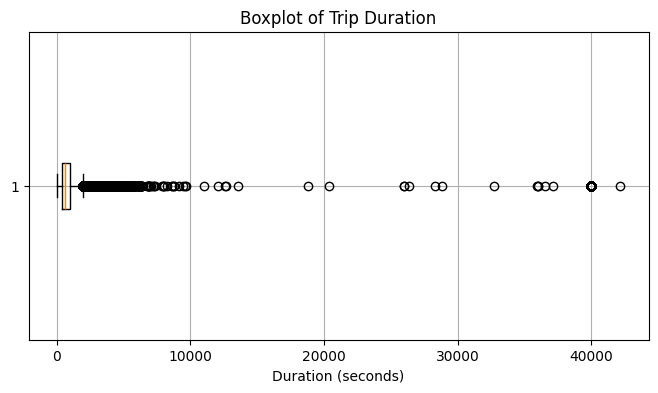

In [114]:
plt.figure(figsize=(8, 4))
plt.boxplot(train['duration'], vert=False)
plt.title("Boxplot of Trip Duration")
plt.xlabel("Duration (seconds)")
plt.grid()
plt.show()


Number of rows before removing outliers: 145001
Number of rows after removing outliers: 137053


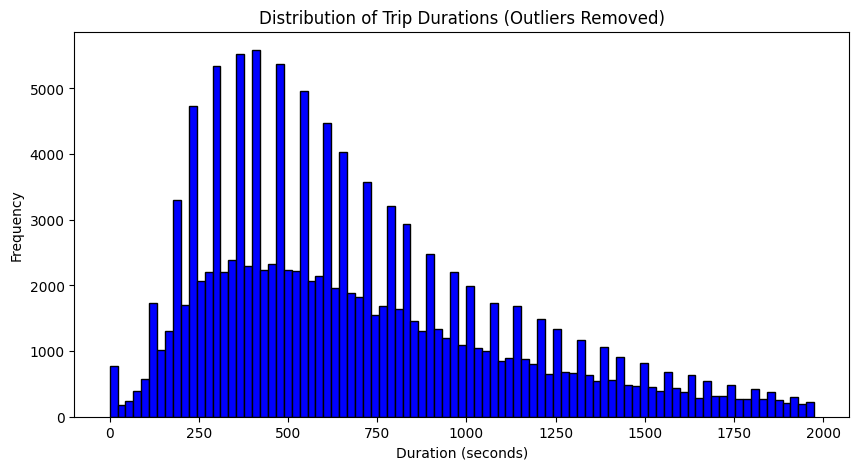

In [119]:
train_no_outliers = train[(train['duration'] >= lower_bound) & (train['duration'] <= upper_bound)]

print("\nNumber of rows before removing outliers:", train.shape[0])
print("Number of rows after removing outliers:", train_no_outliers.shape[0])

plt.figure(figsize=(10, 5))
plt.hist(train_no_outliers['duration'], bins='auto', color='blue', edgecolor='black')
plt.title("Distribution of Trip Durations (Outliers Removed)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()


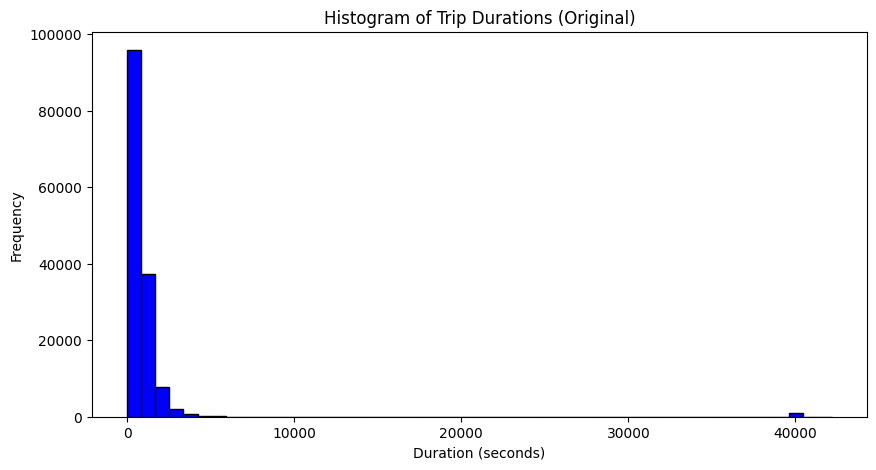

In [120]:
from scipy.stats import skew

plt.figure(figsize=(10, 5))
plt.hist(train['duration'], bins=50, color='blue', edgecolor='black')
plt.title("Histogram of Trip Durations (Original)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

In [121]:
duration_skew = skew(train['duration'])
print("Skewness of original duration:", duration_skew)

Skewness of original duration: 11.241841627424991


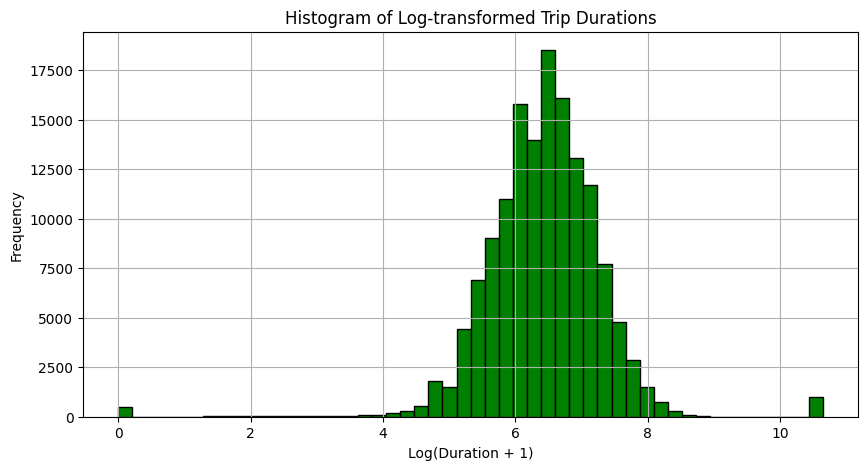

In [123]:
log_duration = np.log1p(train['duration'])

plt.figure(figsize=(10, 5))
plt.hist(log_duration, bins=50, color='green', edgecolor='black')
plt.title("Histogram of Log-transformed Trip Durations")
plt.xlabel("Log(Duration + 1)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [124]:
log_duration_skew = skew(log_duration)
print("Skewness of log-transformed duration:", log_duration_skew)

Skewness of log-transformed duration: -0.8494914130598965


There is a difference in skewness, but we'll check that with the residuals later.

The residuals appear skewed, violating the normality assumption. This can happen if the relationship we are trying to model is non-linear.

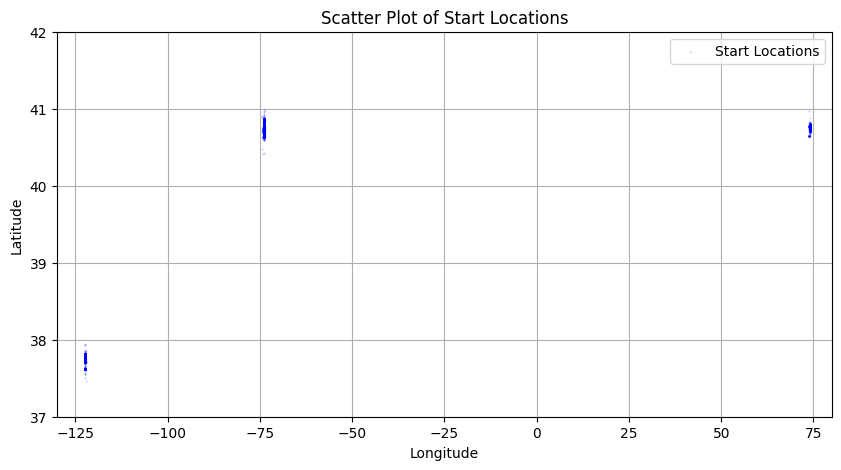

In [62]:
plt.figure(figsize=(10, 5))
plt.scatter(train['start_lng'], train['start_lat'], color='blue', label='Start Locations', marker='.', s=1, alpha=0.2)
plt.title("Scatter Plot of Start Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.xlim([-130,80])
plt.ylim([37,42])
plt.grid()
plt.show()

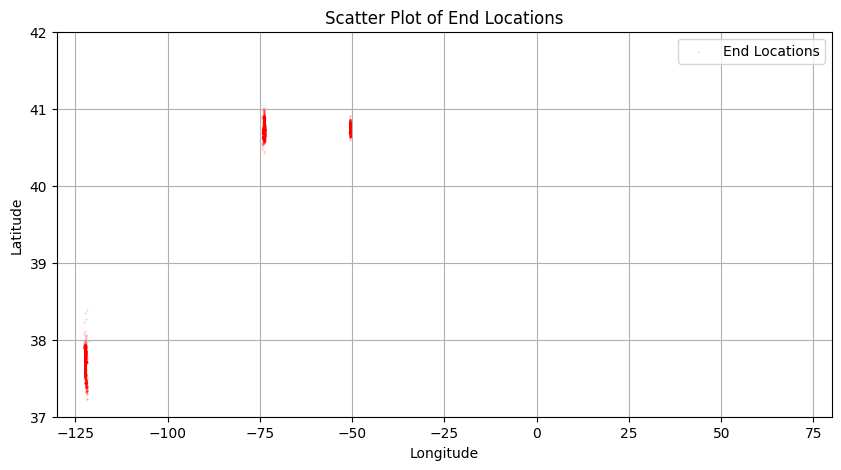

In [58]:
plt.figure(figsize=(10, 5))
plt.scatter(train['end_lng'], train['end_lat'], color='red', label='End Locations', marker='.', s=1, alpha=0.2)
plt.title("Scatter Plot of End Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.xlim([-130,80])
plt.ylim([37,42])
plt.grid()
plt.show()

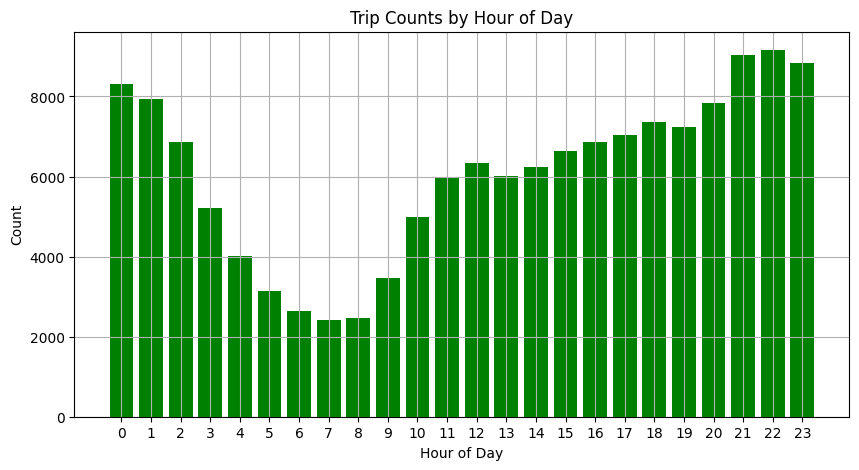

In [64]:
train['hour'] = train['datetime'].dt.hour
hour_counts = train['hour'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(hour_counts.index, hour_counts.values, color='green')
plt.title("Trip Counts by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.xticks(range(0, 24))
plt.grid()
plt.show()

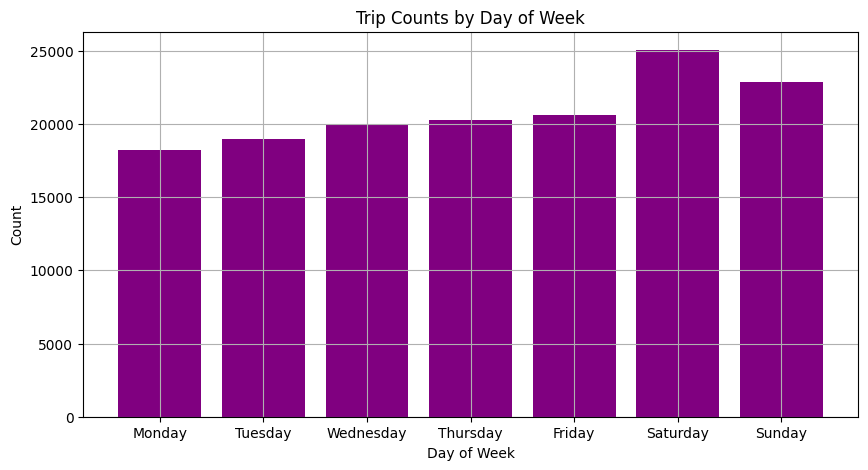

In [65]:
train['dayofweek'] = train['datetime'].dt.dayofweek
day_counts = train['dayofweek'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(day_counts.index, day_counts.values, color='purple')
plt.title("Trip Counts by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.xticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid()
plt.show()

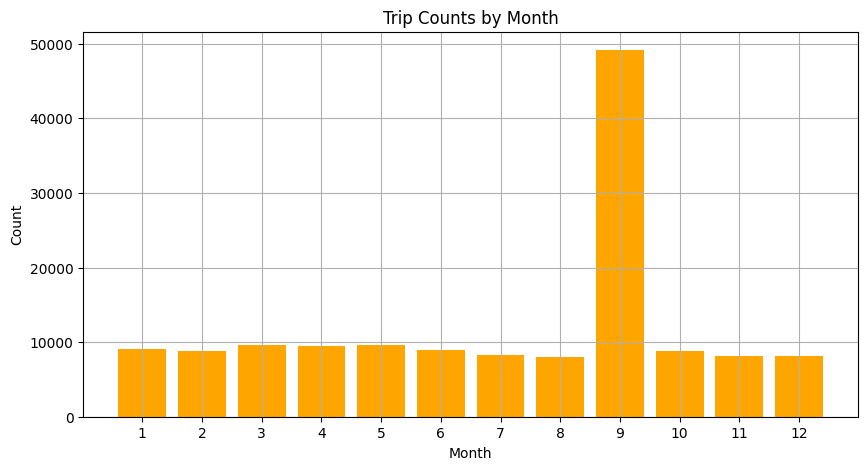

In [66]:
train['month'] = train['datetime'].dt.month
month_counts = train['month'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(month_counts.index, month_counts.values, color='orange')
plt.title("Trip Counts by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(range(1, 13))
plt.grid()
plt.show()

In [80]:
train.drop(columns=['hour', 'dayofweek', 'month'], inplace=True)

# 3. Data Cleaning and Preprocessing

In this step, we ensure that our data is clean and consistent before moving forward with feature engineering and model training.

## Removing Duplicates

- Duplicate rows can bias model training. We remove any duplicated entries.

In [76]:
print("Initial training data shape:", train.shape)
train = train.drop_duplicates()
print("After removing duplicates:", train.shape)

Initial training data shape: (146001, 10)
After removing duplicates: (146001, 10)


## Handling Missing Values  
- For critical features like `start_lng`, `start_lat`, `end_lng`, and `end_lat`, missing values are not acceptable. Rows with missing values in these columns are dropped. (For non-critical columns or if missingness is higher, consider imputation strategies.)
- In the Missing Values Analysis step, we observed the distribution of missing values between the complete data and the missing data. Since the distribution is similar and the share of missing values is small, dropping rows with missing values is a reasonable approach.

In [110]:
train.dropna(subset=['start_lng', 'start_lat', 'end_lng', 'end_lat'], inplace=True)

## Outlier Detection and Removal  
- Outliers in the `duration` field (e.g., durations that fall significantly outside the typical range) can adversely affect the model. We apply the Interquartile Range (IQR) method to detect and remove extreme values.